In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import io
import pandas as pd
from sklearn import svm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
from google.colab import files
uploaded = files.upload()

Saving output1.txt to output1.txt


In [3]:
data = pd.read_csv(io.BytesIO(uploaded['output1.txt']))

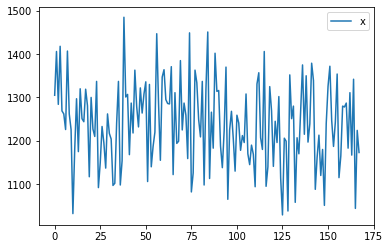

In [4]:
data.plot()


In [5]:
len(data)

168

In [6]:
#Normalizing the data

data_n = data.copy()
data_n = (data - data.min())/(data.max() - data.min())
print(data_n)

            x
0    0.605263
1    0.826754
2    0.559211
3    0.853070
4    0.526316
..        ...
163  0.302632
164  0.686404
165  0.032895
166  0.427632
167  0.315789

[168 rows x 1 columns]


In [7]:
# Create function for the Lag used for the prediction
# We will use 24 for the lag dimension if the series repeats 
# itself daily, 168 if it is weekly

dimensions = 24
data_cn = pd.concat([data_n.shift(i) for i in range(0 + dimensions + 1)], axis = 1)

print(data_cn)

            x         x         x  ...         x         x         x
0    0.605263       NaN       NaN  ...       NaN       NaN       NaN
1    0.826754  0.605263       NaN  ...       NaN       NaN       NaN
2    0.559211  0.826754  0.605263  ...       NaN       NaN       NaN
3    0.853070  0.559211  0.826754  ...       NaN       NaN       NaN
4    0.526316  0.853070  0.559211  ...       NaN       NaN       NaN
..        ...       ...       ...  ...       ...       ...       ...
163  0.302632  0.618421  0.337719  ...  0.767544  0.460526  0.368421
164  0.686404  0.302632  0.618421  ...  0.679825  0.767544  0.460526
165  0.032895  0.686404  0.302632  ...  0.129386  0.679825  0.767544
166  0.427632  0.032895  0.686404  ...  0.291667  0.129386  0.679825
167  0.315789  0.427632  0.032895  ...  0.403509  0.291667  0.129386

[168 rows x 25 columns]


In [8]:
# Splitting the data into train, validation and test

from sklearn.model_selection import train_test_split

X = data_cn.iloc[24:,1:]

y = data_cn.iloc[24:,0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, shuffle = True)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = True)


print(len(y_val))
print(len(y_test))
print(len(y_train))


29
29
86


In [9]:
def pso(n_particles, iterations, dimensions, inertia):

    # Range of SVR's hyperparameters (Particles' search space)
    # C, Epsilon and Gamma
    max_c = 1e4
    min_c = 1e-3
    max_e = 1e-1
    min_e = 1e-8
    max_g = 1e3
    min_g = 1e-3
    
    # Initializing particles' positions randomly, inside
    # the search space
    x = np.random.rand(n_particles, 1)*(max_c - min_c) + min_c
    y = np.random.rand(n_particles, 1)*(max_e - min_e) + min_e
    z = np.random.rand(n_particles, 1)*(max_g - min_g) + min_g

    c = np.concatenate((x,y,z), axis=1)

    # Initializing particles' parameters
    v = np.zeros((n_particles, dimensions))
    c1 = 2
    c2 = 2
    p_best = np.zeros((n_particles, dimensions))
    p_best_val = np.zeros(n_particles) + sys.maxsize  
    g_best = np.zeros(dimensions)
    g_best_val = sys.maxsize

    best_iter = np.zeros(iterations)

    # Initializing regression variables
    p_best_RGS = np.empty((n_particles), dtype = object);
    g_best_RGS = sys.maxsize

    

    # Displaying tridimensional search space
    plot(c)

    from sklearn.metrics import mean_squared_error
    
    for i in range(iterations):

        for j in range(n_particles):
          # Starting Regression
          rgs = svm.SVR(C = c[j][0], epsilon = c[j][1], gamma = c[j][2])

          # Fitting the curve
          rgs.fit(X_train, y_train)
          y_predict = rgs.predict(X_val)

          # Using Mean Squared Error to verify prediction accuracy
          mse = mean_squared_error(y_val, y_predict) 

          # If mse value for that search point, for that particle,
          # is less than its personal best point,
          # replace personal best
          if(mse < p_best_val[j]):   # mse < p_best_val[j]
              # The value below represents the current least Mean Squared Error
              p_best_val[j] = mse
              
              p_best_RGS[j] = rgs
                           

              # The value below represents the current search coordinates for
              # the particle's current least Mean Squared Error found
              p_best[j] = c[j].copy()
              
          # Using auxiliar variable to get the index of the
          # particle that found the configuration with the 
          # minimum MSE value
          aux = np.argmin(p_best_val)        
        
          if(p_best_val[aux] < g_best_val):
              # Assigning Particle's current best MSE to the Group's best    
              g_best_val = p_best_val[aux]

              # Assigning Particle's current best configuration to the Group's best
              g_best = p_best[aux].copy()

              # Group best regressor:
              # the combination of C, Epsilon and Gamma
              # that computes the best fitting curve
              g_best_RGS = p_best_RGS[aux]

        
          rand1 = np.random.random()
          rand2 = np.random.random()

          # The variable below influences directly the particle's velocity.
          # It can either make it smaller or bigger. 
          w = inertia

          # The equation below represents Particle's velocity, which is
          # the rate of change in its position
          v[j] = w*v[j] + c1*(p_best[j] - c[j])*rand1 + c2*(g_best - c[j])*rand2

          # Change in the Particle's position 
          c[j] = c[j] + v[j]

          # Below is a series of conditions that stop the particles from
          # leaving the search space
          if(c[j][2] < min_g):
            c[j][2] = min_g
          if(c[j][2] > max_g):
            c[j][2] = max_g
          if(c[j][1] < min_e):
            c[j][1] = min_e
          if(c[j][1] > max_e):
            c[j][1] = max_e
          if(c[j][0] < min_c):
            c[j][0] = min_c
          if(c[j][0] > max_c):
            c[j][0] = max_c
            
     
        # The variable below represents the least Mean Squared Error
        # of the current iteration
        best_iter[i] = g_best_val
                
        print('Best value iteration # %d = %f\n'%(i, g_best_val))

    # Coordinates found after all the iterations
    print('Group Best configuration found: ')
    print(g_best)
    print('\n')
    print('Best Regressor:\n')
    print(g_best_RGS)
    print('\n')
    # Displaying the MSE value variation throughout the iterations
    t = range(iterations)
    plt.plot(t, best_iter, label='Fitness Value')
    plt.legend()
    plt.show()

    # Displaying Particles' final configuration
    plot(c)

    # Making the prediction with the best configuration of C, Epsilon and
    # Gamma found by the particles
    predict_test = g_best_RGS.predict(X_test)

    
    # Displaying actual values and predicted values for
    # Group's best configuration found overall
    print(color.BOLD + 'Predictions with the Population Best Value found:\n' + color.END)
    evaluate(predict_test)  
      


In [10]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'



In [11]:
# Function that displays tridimensional plot
def plot(some_list):
 
  ax = Axes3D(plt.figure())
  ax.scatter3D(some_list[:,0], some_list[:,1], some_list[:,2], color = 'r')
  ax.set_xlabel('$C$', fontsize = 20)
  ax.set_ylabel('$\epsilon$', fontsize = 25)
  ax.zaxis.set_rotate_label(False) 
  ax.set_zlabel('$\gamma$', fontsize=30, rotation = 0)
  ax.zaxis._axinfo['label']['space_factor'] = 1.0
  plt.show()

  print('\n')
  print('\n')

In [12]:
def evaluate(predictions):

    from sklearn.metrics import mean_squared_error
    import statistics as st

    predict_test = predictions

    # To un-normalize the data:
    # Multiply the values by
    # data.to_numpy().max()

    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted')
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(y_test, predict_test)
    print('\n')
    print('\n')
    print('Mean Squared Error for the Test Set:\t %f' %mse)
    print('\n')
    print('\n')
    print('Predictions Average:\t %f' %((predict_test.sum()/len(predict_test))))
    print('\n')
    print('\n')
    print('Predictions Median:\t %f' %(st.median(predict_test)))
    print('\n')
    print('\n')

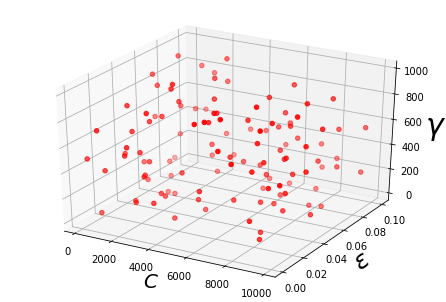





Best value iteration # 0 = 0.048640

Best value iteration # 1 = 0.047017

Best value iteration # 2 = 0.047017

Best value iteration # 3 = 0.047017

Best value iteration # 4 = 0.047017

Best value iteration # 5 = 0.047017

Best value iteration # 6 = 0.047017

Best value iteration # 7 = 0.047017

Best value iteration # 8 = 0.046495

Best value iteration # 9 = 0.046495

Best value iteration # 10 = 0.046300

Best value iteration # 11 = 0.046300

Best value iteration # 12 = 0.046300

Best value iteration # 13 = 0.046300

Best value iteration # 14 = 0.046300

Best value iteration # 15 = 0.046299

Best value iteration # 16 = 0.046291

Best value iteration # 17 = 0.046291

Best value iteration # 18 = 0.046291

Best value iteration # 19 = 0.046291

Best value iteration # 20 = 0.046291

Best value iteration # 21 = 0.046291

Best value iteration # 22 = 0.046291

Best value iteration # 23 = 0.046291

Best value iteration # 24 = 0.046291

Best value iteration # 25 = 0.046291

Best value iterati

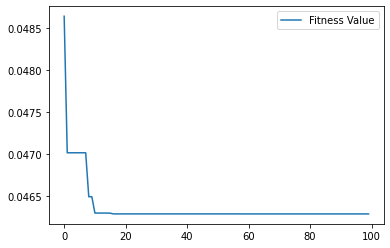

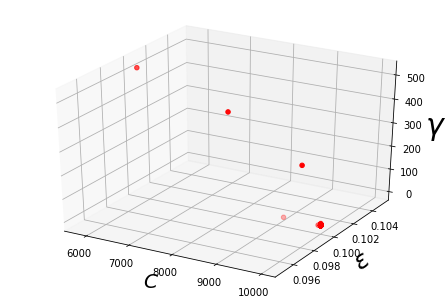





Predictions with the Population Best Value found:



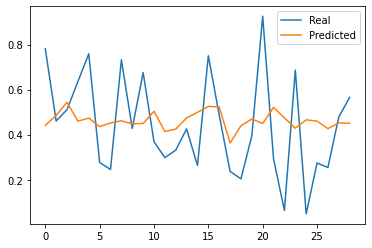





Mean Squared Error for the Test Set:	 0.048835




Predictions Average:	 0.462601




Predictions Median:	 0.459812






In [13]:
pso(120, 100, 3, 1)

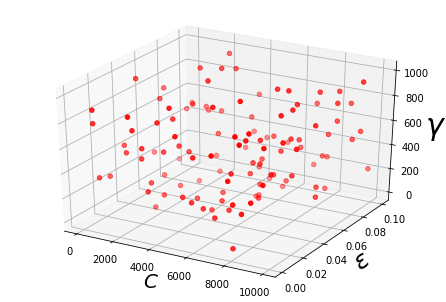





Best value iteration # 0 = 0.048259

Best value iteration # 1 = 0.048259

Best value iteration # 2 = 0.046847

Best value iteration # 3 = 0.046847

Best value iteration # 4 = 0.046737

Best value iteration # 5 = 0.046737

Best value iteration # 6 = 0.046712

Best value iteration # 7 = 0.046712

Best value iteration # 8 = 0.046712

Best value iteration # 9 = 0.046681

Best value iteration # 10 = 0.046681

Best value iteration # 11 = 0.046674

Best value iteration # 12 = 0.046674

Best value iteration # 13 = 0.046674

Best value iteration # 14 = 0.046674

Best value iteration # 15 = 0.046673

Best value iteration # 16 = 0.046673

Best value iteration # 17 = 0.046673

Best value iteration # 18 = 0.046673

Best value iteration # 19 = 0.046673

Best value iteration # 20 = 0.046673

Best value iteration # 21 = 0.046672

Best value iteration # 22 = 0.046672

Best value iteration # 23 = 0.046672

Best value iteration # 24 = 0.046672

Best value iteration # 25 = 0.046671

Best value iterati

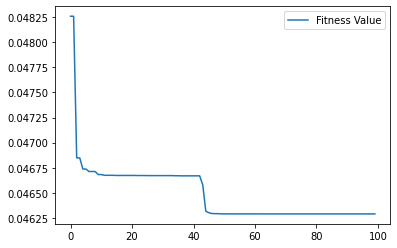

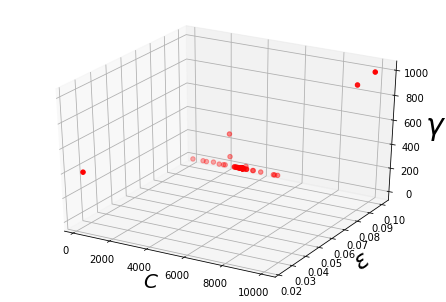





Predictions with the Population Best Value found:



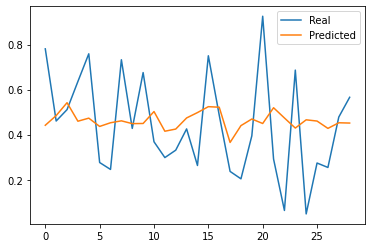





Mean Squared Error for the Test Set:	 0.048842




Predictions Average:	 0.462606




Predictions Median:	 0.459597






In [14]:
pso(120, 100, 3, 0.6)